/home/manjunath/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_62757/296568416.py:105: RuntimeWarning: invalid value encountered in sqrt
  mu_grid = np.sqrt(1 - R**2)


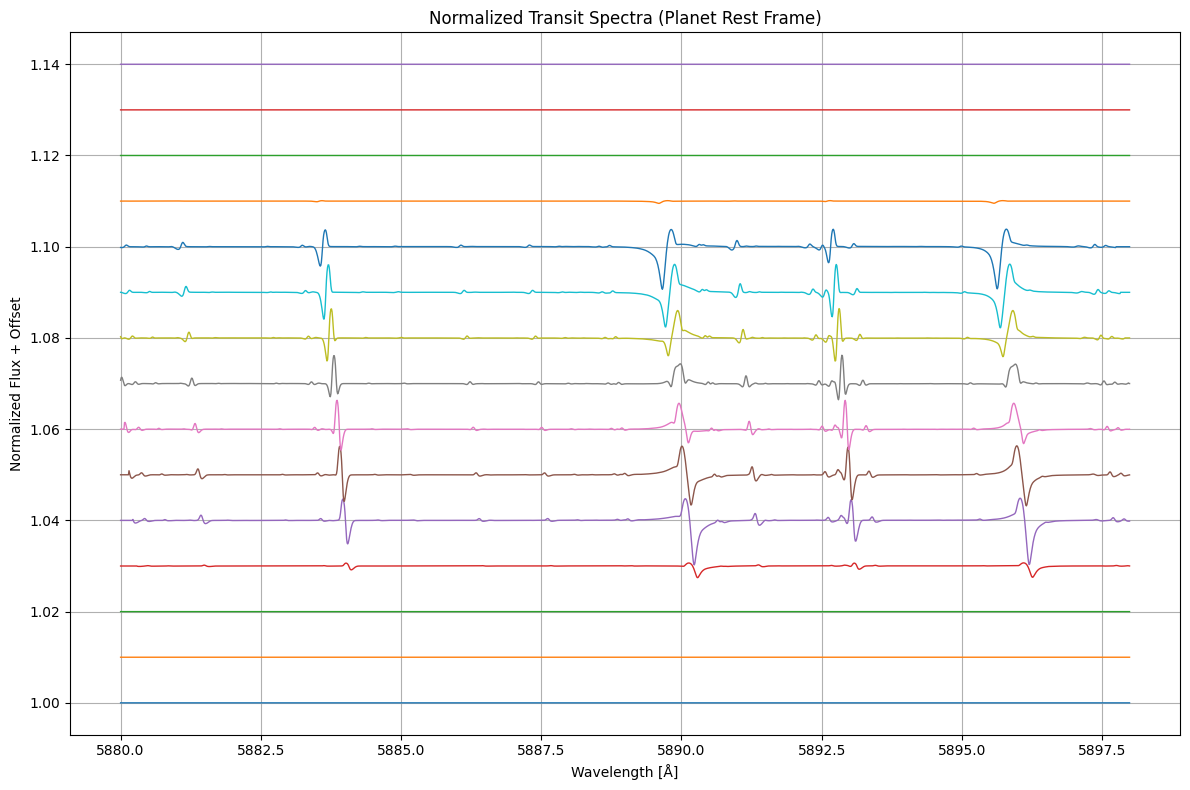

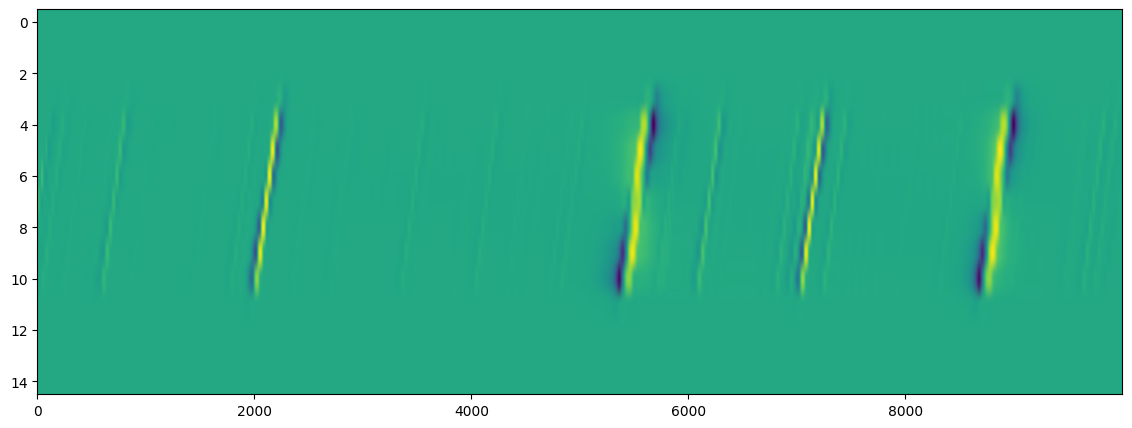

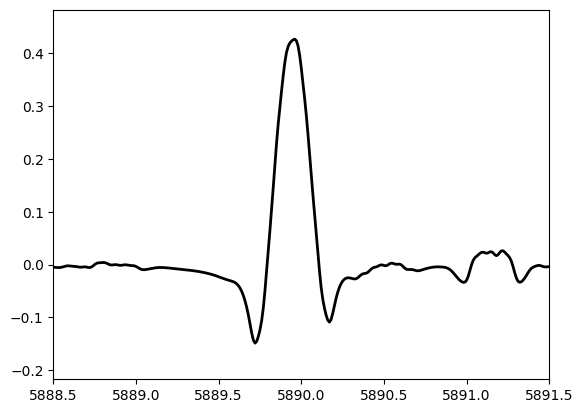

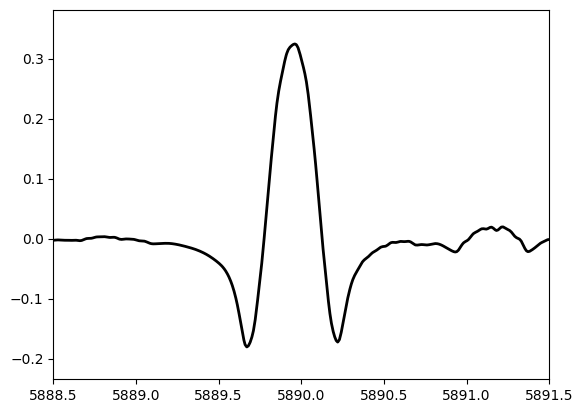

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import modelSuite as ms
from PyAstronomy.pyasl import spectralLib
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from spectrum_overload import Spectrum
from matplotlib.gridspec import GridSpec
from astropy.time import Time


# === Constants ===
deg2rad = np.pi / 180.0
R_sun_m = 6.957e8
R_star = 1.155
R_star_m = R_star * R_sun_m
c = 299792458.0  # m/s


# === Initialize RM model ===
rmcl = ms.RmcL()
rmcl.assignValue({
    "a": 8.76,
    "lambda": -1.6 * deg2rad,
    "epsilon": 0.64,
    "gamma": 0.12086,
    "P": 3.52474859,
    "T0": 2452826.62980,
    "i": 86.71 * deg2rad,
    "Is": 90.0 * deg2rad,
    "Omega": (4.70 * 1000) / (R_star_m * np.sin(90.0 * deg2rad))
})

# === Observation times ===
times_JD = (np.array([
    60238.566219, 60238.580669, 60238.596685,
    60238.611167, 60238.625685, 60238.640963,
    60238.655472, 60238.671618, 60238.686587,
    60238.701199, 60238.716508, 60238.731044,
    60238.746116, 60238.760616, 60238.775326
]) + 2400000.5) + (10 / (24 * 60))


phase = np.array((times_JD-rmcl["T0"])/rmcl["P"])


# Calculate RV anomalies
rv_anomalies = rmcl.evaluate(times_JD) * R_star_m

na_wave = np.tile(np.linspace(5880, 5898, 10000), (len(times_JD), 1))

# === Planet radial velocity function ===


# === Planet radial velocity function ===
def planet_radial_velocity(t, P, K, T0):
    M = 2 * np.pi * (t - T0) / P
    return K * np.sin(M)

K_planet = 144890  # m/s (adjust this based on your planet)
rv_planet = planet_radial_velocity(times_JD, rmcl["P"], K_planet, rmcl["T0"])

# === Load spectral library ===
sl = spectralLib.SpectralLib()
musfn = sl.requestModel(6250, 4.5, 0.0, nex="muspecs")
w_full, mus_orig, intens_full = sl.readMuFits(musfn)

# === Wavelength mask (Na D) ===
wlmin, wlmax = np.min(na_wave[0]), np.max(na_wave[-1])
indi = (w_full > wlmin) & (w_full < wlmax)
w = w_full[indi]
w_all  = w_full[indi]
intens = intens_full[indi, :]

nts_y = []
for i in range(intens.shape[1]):
        s = Spectrum(flux = intens[:,i], xaxis = w)
        # plt.plot(s.flux)
        s = s.normalize("poly",degree = 1)
        continuum = s.continuum(method = "poly", degree=3,nbins = 35, ntop = 35)
        # plt.plot(continuum.flux)
        n = s/continuum
        ts_y =  n.flux
        nts_y.append(ts_y)
        # plt.plot(ts_y)
        # plt.plot(continuum.flux)
        # plt.show()

nts_y = (np.array(nts_y))

# === Interpolate over mu ===
interp_wave = interp1d(mus_orig, nts_y, kind='cubic', axis=0, bounds_error=False, fill_value="extrapolate")
mus = np.linspace(0.05, 1.0, 100)
intens_interp = interp_wave(mus)

# === Stellar disk grid ===
grid_resolution = 0.01
x = np.arange(-1, 1 + grid_resolution, grid_resolution)
y = np.arange(-1, 1 + grid_resolution, grid_resolution)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
disk_mask = R <= 1.0
mu_grid = np.sqrt(1 - R**2)
mu_grid[~disk_mask] = 0
V_rot = rmcl["Omega"] * X * R_star_m
V_rot[~disk_mask] = 0

# === Transit parameters ===
Rp_Rs = rmcl["gamma"]
impact_param = rmcl["a"] * np.cos(rmcl["i"])

# === Spectrum synthesis ===
def calculate_spectrum(planet_mask):
    spectrum = np.zeros_like(w)
    total_weight = 0.0
    for ix in range(X.shape[0]):
        for iy in range(X.shape[1]):
            if disk_mask[ix, iy] and not planet_mask[ix, iy]:
                mu = mu_grid[ix, iy]
                if mu > 0:
                    mu_idx = np.argmin(np.abs(mus - mu))
                    pixel_spec = intens_interp[mu_idx]
                    delta_w = w * (V_rot[ix, iy] / c)
                    shifted_w = w + delta_w
                    pixel_spec = np.interp(w, shifted_w, pixel_spec, left=1.0, right=1.0)
                    spectrum += pixel_spec * mu
                    total_weight += mu
    if total_weight > 0:
        spectrum /= total_weight
    return spectrum

# === Build median out-of-transit spectrum ===
oot_spectra = []
for time_idx, t in enumerate(times_JD):
    phase_rm = (t - rmcl["T0"]) / rmcl["P"] % 1.0
    x_planet = rmcl["a"] * np.sin(2 * np.pi * phase_rm)
    y_planet = impact_param * np.cos(2 * np.pi * phase_rm)
    dist = np.sqrt(x_planet**2 + y_planet**2)
    if dist > 1.0 + Rp_Rs:
        planet_mask = np.zeros_like(disk_mask, dtype=bool)
        oot_spec = calculate_spectrum(planet_mask)
        oot_spectra.append(oot_spec)

oot_median = np.median(np.array(oot_spectra), axis=0)

# === Plot normalized spectra in planet rest frame ===
plt.figure(figsize=(12, 8))
t_offset = 0
all_spectra_planet_frame = []
all_spectra_stellar_frame = []

for time_idx, t in enumerate(times_JD):
    phase_rm = (t - rmcl["T0"]) / rmcl["P"]
    x_planet = rmcl["a"] * np.sin(2 * np.pi * phase_rm)
    y_planet = impact_param * np.cos(2 * np.pi * phase_rm)

    planet_mask = ((X - x_planet)**2 + (Y - y_planet)**2) <= Rp_Rs**2
    transit_spec = calculate_spectrum(planet_mask)

    # Normalize and shift to planet rest frame
    norm_spec = transit_spec / oot_median
    delta_lambda = w * (-rv_planet[time_idx] / c)
    shifted_lambda = w + delta_lambda
    norm_shifted = np.interp(w, shifted_lambda, norm_spec, left=1.0, right=1.0)

    all_spectra_planet_frame.append(norm_shifted)
    all_spectra_stellar_frame.append(norm_spec)

    plt.plot(w, norm_shifted + t_offset, lw=1)
    t_offset += 0.01

plt.xlabel("Wavelength [Å]")
plt.ylabel("Normalized Flux + Offset")
plt.title("Normalized Transit Spectra (Planet Rest Frame)")
plt.grid(True)
plt.tight_layout()
plt.show()



# === Resample all spectra to na_wave ===
na_wave_grid = na_wave[0]  # assuming na_wave is shape (2, N), or na_wave[0] is your wavelength array

# Resample each spectrum
resampled_spectra_rm = [np.interp(na_wave_grid, w, spec) for spec in all_spectra_planet_frame]

# Convert to 2D numpy array
resampled_spectra_rm = np.array(resampled_spectra_rm)  # shape: (n_times, len(na_wave_grid))

plt.figure(figsize=(14, 5))
plt.imshow(resampled_spectra_rm-1,aspect='auto')
plt.show()


plt.plot(w, (np.mean(all_spectra_planet_frame[5:10],axis=0)-1)*100, 'k-', lw=2.0)
plt.xlim(5888.5, 5891.5)
plt.show()

plt.plot(na_wave_grid,(np.mean(resampled_spectra_rm[4:11], axis=0)-1)*100, 'k-', lw=2.0)
plt.xlim(5888.5,5891.5)
plt.show()

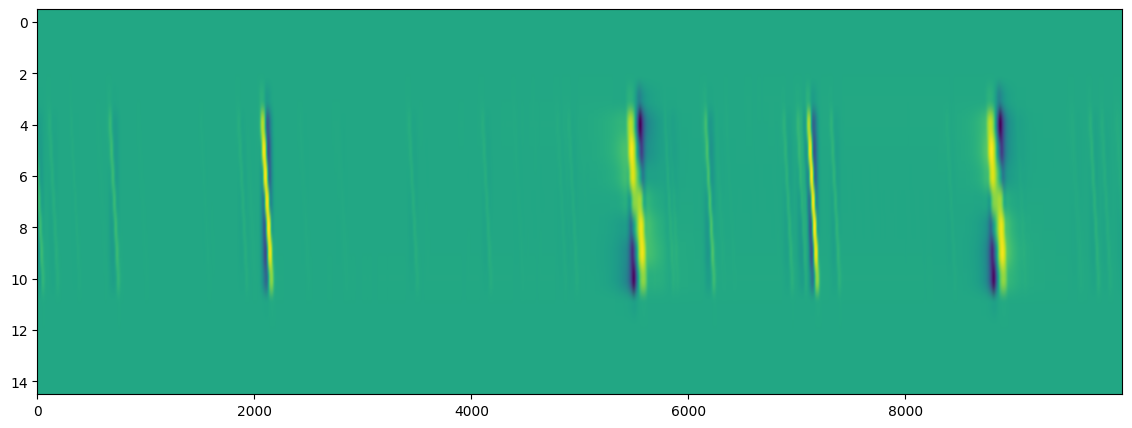

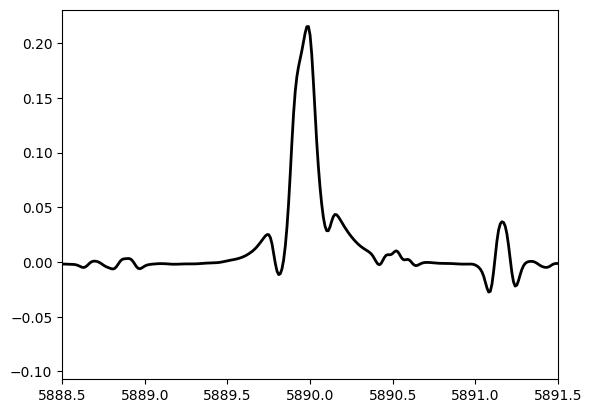

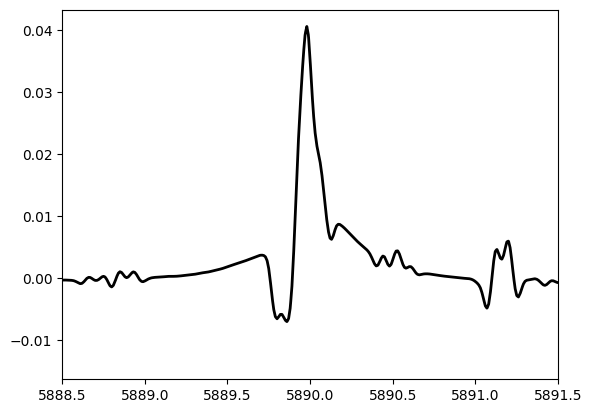

In [2]:
# === Resample all spectra to na_wave ===
na_wave_grid = na_wave[0]  # assuming na_wave is shape (2, N), or na_wave[0] is your wavelength array

# Resample each spectrum
resampled_spectra_rm = [np.interp(na_wave_grid, w, spec) for spec in all_spectra_stellar_frame]

# Convert to 2D numpy array
resampled_spectra_rm = np.array(resampled_spectra_rm)  # shape: (n_times, len(na_wave_grid))

plt.figure(figsize=(14, 5))
plt.imshow(resampled_spectra_rm-1,aspect='auto')
plt.show()


plt.plot(w, (np.mean(all_spectra_stellar_frame[5:10],axis=0)-1)*100, 'k-', lw=2.0)
plt.xlim(5888.5, 5891.5)
plt.show()

plt.plot(na_wave_grid,(np.mean(resampled_spectra_rm[4:11], axis=0)-1)*100, 'k-', lw=2.0)
plt.xlim(5888.5,5891.5)
plt.show()

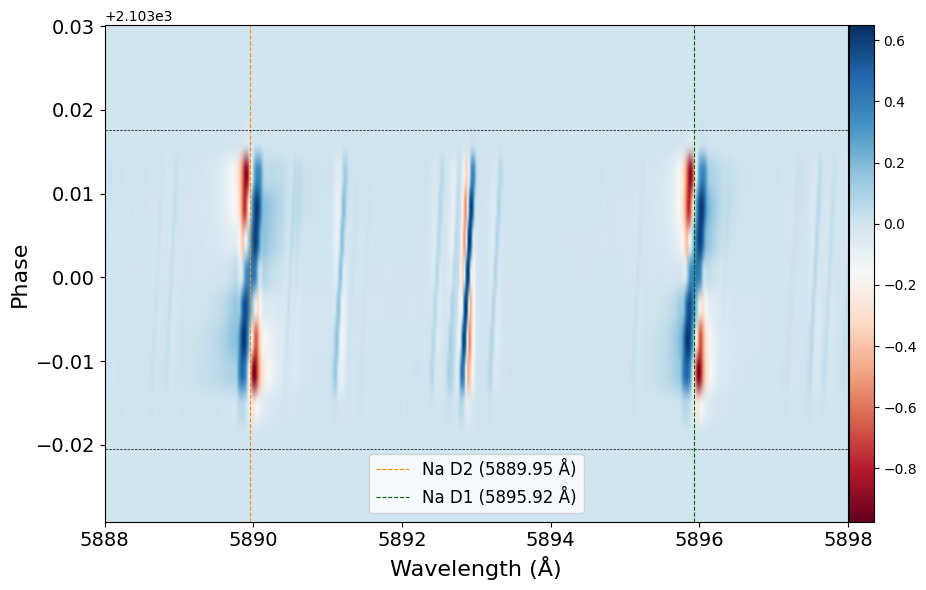

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# === Resample all spectra to na_wave ===
na_wave_grid = na_wave[0]  # assuming na_wave is shape (2, N), or na_wave[0] is your wavelength array

# Resample each spectrum
resampled_spectra_rm = [np.interp(na_wave_grid, w, spec) for spec in all_spectra_stellar_frame]

# Convert to 2D numpy array
resampled_spectra_rm = np.array(resampled_spectra_rm)  # shape: (n_times, len(na_wave_grid))

# Plot the 2D image
im = plt.imshow(
    (resampled_spectra_rm-1)*100, 
    aspect='auto',
    extent=[na_wave[0][0], na_wave[0][-1], phase[0], phase[-1]],
    origin='lower',  # So phase increases upwards
   cmap='RdBu'   # Or 'inferno', 'plasma', etc. depending on your aesthetic
)

# Limit wavelength range to sodium lines
plt.xlim(5888, 5898)

# Vertical lines for Na D1 and D2
plt.axvline(5889.950, color='darkorange', linestyle='--', linewidth=0.8, label='Na D2 (5889.95 Å)')
plt.axvline(5895.924, color='darkgreen', linestyle='--', linewidth=0.8, label='Na D1 (5895.92 Å)')

# Add horizontal lines at phase[3] and phase[12]
plt.axhline(y=phase[2], color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=phase[11], color='black', linestyle='--', linewidth=0.5)

# Axis labels and title
plt.xlabel('Wavelength (Å)', fontsize=16)
plt.ylabel('Phase', fontsize=16)

# Add colorbar
cbar = plt.colorbar(im, pad=0.001)
# cbar.set_label('Normalized Flux', fontsize=12)

# Ticks and font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Legend
plt.legend(loc='lower center', fontsize=12, frameon=True)

# Tight layout for saving
plt.tight_layout()
# Show the figure
plt.show()

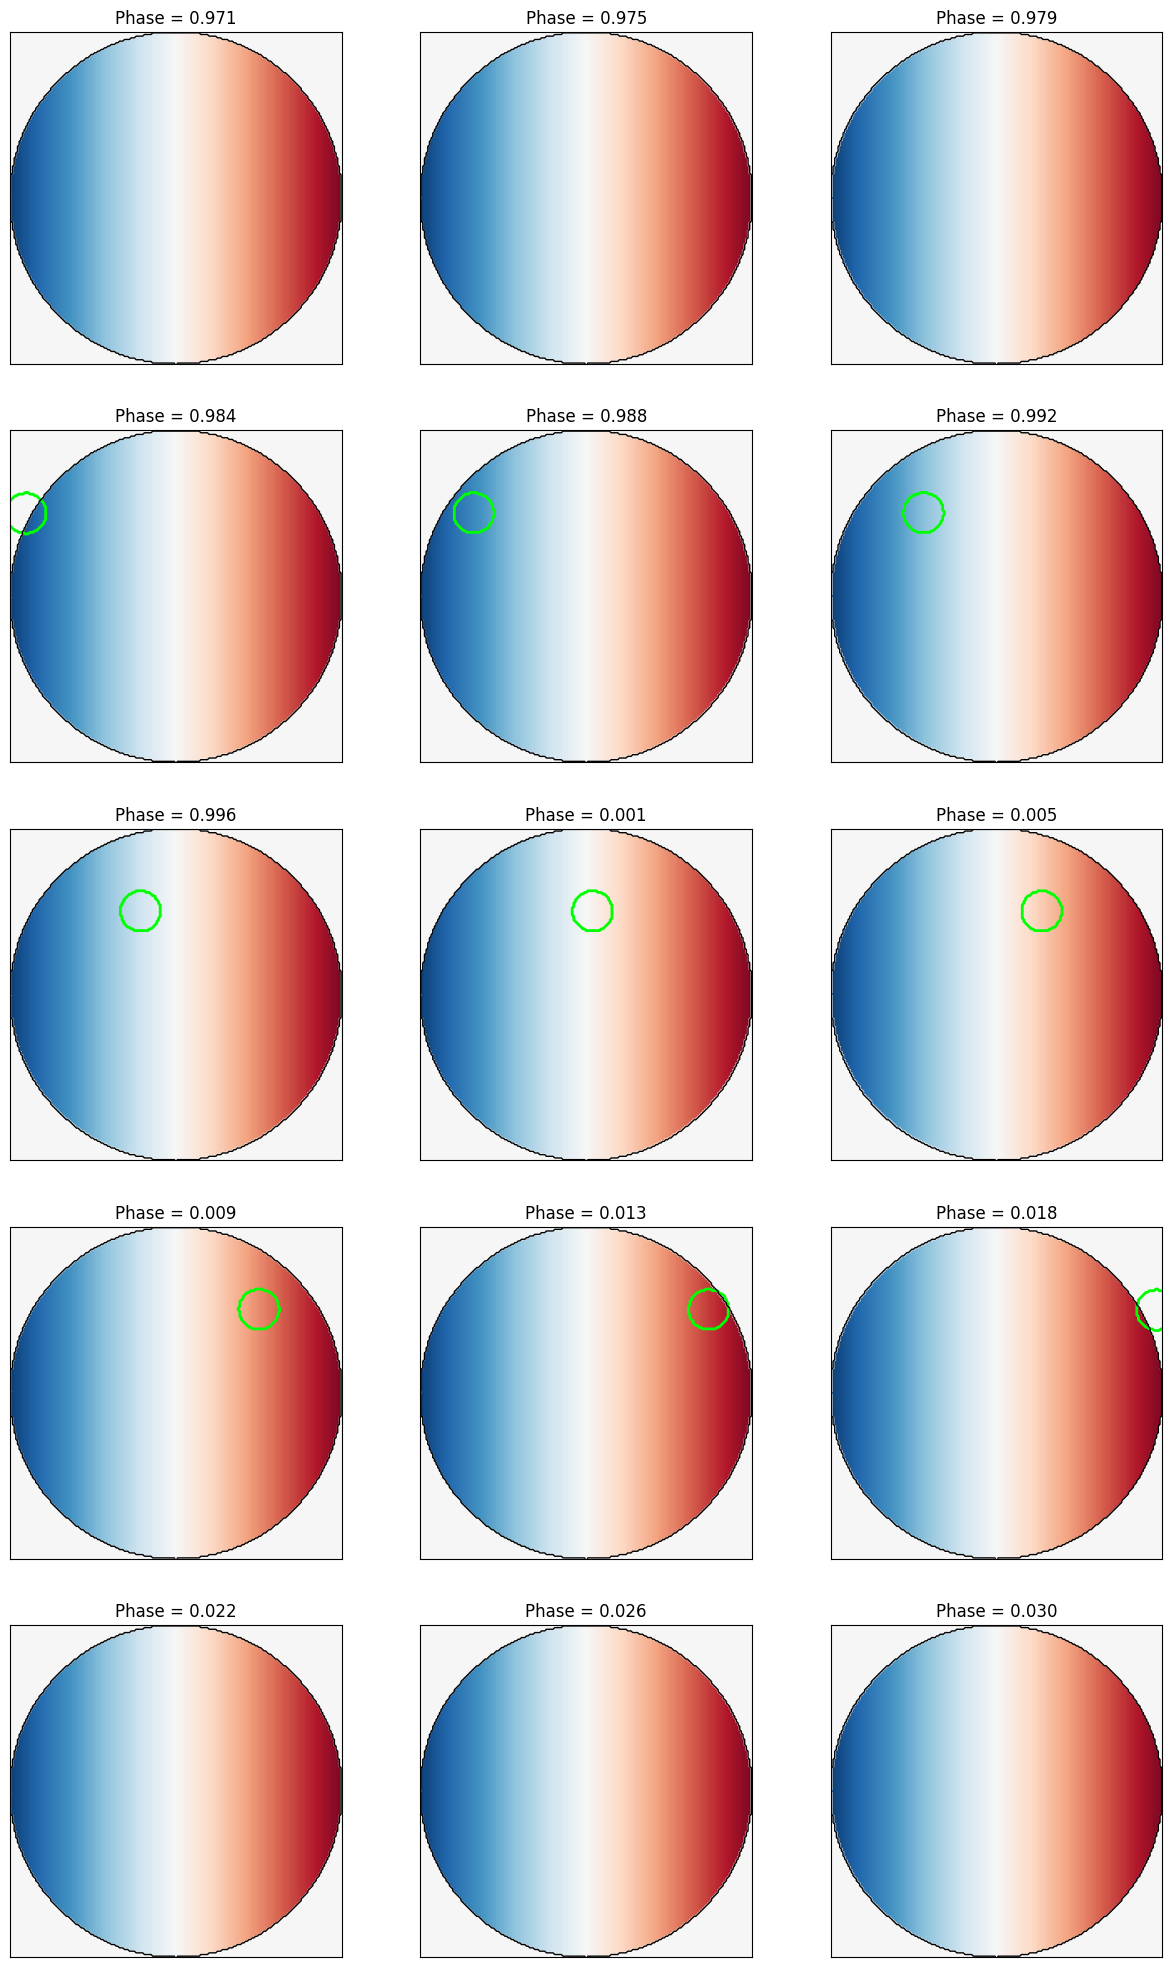

In [4]:
# === Plot 1: Star-Planet Maps ===
fig1, axes1 = plt.subplots(nrows=5, ncols=3, figsize=(15, 25))
axes1 = axes1.flatten()

for time_idx, t in enumerate(times_JD):
    phase = ((t - rmcl["T0"]) / rmcl["P"]) % 1
    x_planet = rmcl["a"] * np.sin(2 * np.pi * phase)
    y_planet = impact_param * np.cos(2 * np.pi * phase)
    planet_mask = ((X - x_planet)**2 + (Y - y_planet)**2) <= Rp_Rs**2
    
    # -- Star-Planet plot --
    ax_disk = axes1[time_idx]
    im = ax_disk.imshow(V_rot, extent=[-1, 1, -1, 1], origin='lower',
                        cmap='RdBu_r', vmin=-5000, vmax=5000)
    ax_disk.contour(X, Y, planet_mask, colors='lime', linewidths=2)
    ax_disk.contour(X, Y, disk_mask, colors='k', linewidths=1)
    ax_disk.set_title(f"Phase = {phase:.3f}")
    ax_disk.set_aspect('equal')
    ax_disk.set_xticks([])
    ax_disk.set_yticks([])

    